In [ ]:
# Allow notebook to import from sibling folder
import sys, os
import pandas as pd
sys.path.append(os.path.abspath(".."))
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder


In [ ]:
#Which factors influence credit risk --> 
#credit history and dti ratio = loan amount/income according to the research...

#1. Load the Preprocessed data
df_formodel = pd.read_csv("../Data_Preprocessing/cleaned_data.csv")

#If applicantIncome is 0, replace it with 1 to avoid division by zero
df_formodel['ApplicantIncome'] = df_formodel['ApplicantIncome'].replace(0, 1)

#2. Calculate dti ratio
df_formodel['dti_ratio'] = df_formodel['LoanAmount'] / df_formodel['ApplicantIncome']
df_formodel['dti_ratio'] = df_formodel['dti_ratio'].clip(0, 2)


#3. Calculate credit score manually
df_formodel['proxy_credit'] = (df_formodel['Credit_History'] * 70 +  (1 - df_formodel['dti_ratio']) * 30 )

#print("Check for NaNs in proxy_credit:")
#print(df_formodel['proxy_credit'].isna().sum())

#print("Min and Max of proxy_credit before scaling:")
#print("Min:", df_formodel['proxy_credit'].min())
#print("Max:", df_formodel['proxy_credit'].max())

# Scale to 300-850 range (standard credit score)
min_val = df_formodel['proxy_credit'].min()
max_val = df_formodel['proxy_credit'].max()
df_formodel['proxy_credit'] = ((df_formodel['proxy_credit'] - min_val) / (max_val - min_val)) * (850-300) + 300


#4. Create a new column for credit score
df_formodel['credit_score'] = df_formodel['proxy_credit'].round(0).astype(int)
#5. Create a new column for dti ratio
df_formodel['dti_ratio'] = df_formodel['dti_ratio'].round(2)

print(df_formodel[['LoanAmount', 'ApplicantIncome','Credit_History', 'credit_score', 'dti_ratio']].head())



   LoanAmount  ApplicantIncome  Credit_History  credit_score  dti_ratio
0       110.0             5720             1.0           848       0.02
1       126.0             3076             1.0           845       0.04
2       208.0             5000             1.0           845       0.04
3       100.0             2340             1.0           845       0.04
4        78.0             3276             1.0           847       0.02


In [92]:
#Credit Tier
def credit_tier(score):
    if 800 <= score <= 850:
        return 'Excellent'
    elif 730 <= score <= 799:
        return 'Very Good'
    elif 670 <= score <= 729:
        return 'Good'
    elif 580 <= score <= 669:
        return 'Fair'
    elif 330 <= score <= 579:
        return 'poor'
    else:
        return 'Very Poor'

df_formodel['credit_tier'] = df_formodel['credit_score'].apply(credit_tier)
print(df_formodel[['credit_score', 'credit_tier']].head(10))

   credit_score credit_tier
0           848   Excellent
1           845   Excellent
2           845   Excellent
3           845   Excellent
4           847   Excellent
5           841   Excellent
6           847   Excellent
7           549        poor
8           848   Excellent
9           844   Excellent


In [93]:
#6. Split the data into train, validate and test sets
features = df_formodel.drop(columns=['proxy_credit', 'credit_score','Loan_ID', 'dataset_name'])  # input columns
target = df_formodel['credit_score']  # or df_formodel['credit_tier'] for classification

# First split: Train (70%) vs Temp (30%)
x_train, x_temp, y_train, y_temp = train_test_split(
    features, target, test_size=0.30, random_state=42
)

# Second split: Validation (15%) vs Test (15%) from the temp set
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.50, random_state=42
)

# Final check
print(f"Train:     {len(x_train)} rows ({len(x_train)/len(df_formodel):.0%})")
print(f"Validate:  {len(x_val)} rows ({len(x_val)/len(df_formodel):.0%})")
print(f"Test:      {len(x_test)} rows ({len(x_test)/len(df_formodel):.0%})")



Train:     513 rows (70%)
Validate:  110 rows (15%)
Test:      111 rows (15%)


In [94]:
# Convert object columns to 'category' (optional but explicit)
#categorical_cols = ['Gender', 'Married', 'Property_Area', 'Education', 'Self_Employed', 'Dependents']
#for col in categorical_cols:
 #   df_formodel[col] = df_formodel[col].astype('category')

#print(df_formodel[categorical_cols].dtypes)

# One-hot encode categoricals
#encoder = OneHotEncoder(drop='first', sparse_output=False)
#encoded_features = encoder.fit_transform(df_formodel[categorical_cols])
#encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Combine with numeric features
#numeric_features = df_formodel.drop(columns=categorical_cols + ['credit_score'])
#df_processed = pd.concat([numeric_features, encoded_df], axis=1)


In [95]:
# Select categorical columns
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'credit_tier']

# Apply one-hot encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # drop_first avoids multicollinearity
encoded_features = encoder.fit_transform(df_formodel[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and concatenate encoded ones
df_numeric = df_formodel.drop(columns=categorical_cols + ['Loan_ID', 'dataset_name'])  # Drop non-feature columns
df_processed = pd.concat([df_numeric, encoded_df], axis=1)

In [96]:

#RE-split the data into train, validate and test sets

featuresp = df_processed.drop(columns=['proxy_credit', 'credit_score'])  # input columns
# Step 2: Add noise to credit_score (after scaling)
np.random.seed(42)
df_processed['credit_score'] += np.random.normal(0, 10, len(df_processed)).round()
df_processed['credit_score'] = df_processed['credit_score'].clip(300, 850).astype(int)

targetp = df_processed['credit_score']  # or df_formodel['credit_tier'] for classification

# First split: Train (70%) vs Temp (30%)
x_trainp, x_tempp, y_trainp, y_tempp = train_test_split(
    featuresp, targetp, test_size=0.30, random_state=42
)

# Second split: Validation (15%) vs Test (15%) from the temp set
x_valp, x_testp, y_valp, y_testp = train_test_split(
    x_tempp, y_tempp, test_size=0.50, random_state=42
)

# Final check
print(f"Train:     {len(x_trainp)} rows ({len(x_trainp)/len(df_processed):.0%})")
print(f"Validate:  {len(x_valp)} rows ({len(x_valp)/len(df_processed):.0%})")
print(f"Test:      {len(x_testp)} rows ({len(x_testp)/len(df_processed):.0%})")

Train:     513 rows (70%)
Validate:  110 rows (15%)
Test:      111 rows (15%)


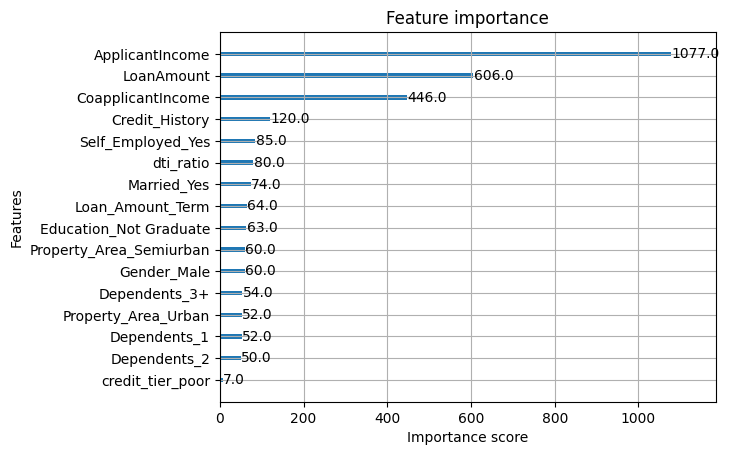

In [ ]:
#7. Train the model on best proxy score

# Instantiation
xgb_r = xg.XGBRegressor(
    objective='reg:squarederror', 
    tree_method='hist',  
    n_estimators=100,
    seed=123
)

# Fitting the model
xgb_r.fit(x_trainp, y_trainp)

# Predict the model
pred = xgb_r.predict(x_testp)


#8. Evaluate the model on test set

In [98]:
def decode_vector(vector):
    max_depth = int(3 + vector[0] * 7) # [3, 10]
    learning_rate = 0.01 + vector[1] * 0.29 # [0.01, 0.3]
    subsample = 0.5 + vector[2] * 0.5 # [0.5, 1]
    colsample_bytree = 0.5 + vector[3] * 0.5 # [0.5, 1]
    return max_depth, learning_rate, subsample, colsample_bytree

In [99]:
def evaluate_fitness(vector):
    max_depth, learning_rate, subsample, colsample_bytree = decode_vector(vector)
    model = xg.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=30, # reduced for speed
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        tree_method='hist',
        seed=42,
        verbosity=0
    )
    model.fit(x_trainp, y_trainp)
    preds = model.predict(x_valp)
    rmse = np.sqrt(mean_squared_error(y_valp, preds))
    return -rmse # lower RMSE = higher fitness

In [100]:
def four_vector_optimization(pop_size=5, iterations=5, alpha=0.1):
    population = np.random.rand(pop_size, 4) # 4D vectors in [0,1]
    fitness = np.array([evaluate_fitness(ind) for ind in population])
    best_idx = np.argmax(fitness)
    best_vector = population[best_idx].copy()
    for it in range(iterations):
        for i in range(pop_size):
            new_vector = population[i] + alpha * (best_vector - population[i]) + alpha * np.random.rand(4)
            new_vector = np.clip(new_vector, 0, 1)  # keep in bounds
            new_fitness = evaluate_fitness(new_vector)
            if new_fitness > fitness[i]:
                population[i] = new_vector
                fitness[i] = new_fitness
                if new_fitness > fitness[best_idx]:
                    best_idx = i
                    best_vector = new_vector.copy()

    return decode_vector(best_vector), -fitness[best_idx]

In [101]:
best_params, best_rmse = four_vector_optimization()
print("Best Hyperparameters (decoded):")
print(f" max_depth: {best_params[0]}")
print(f" learning_rate: {best_params[1]:.4f}")
print(f" subsample: {best_params[2]:.4f}")
print(f" colsample_bytree: {best_params[3]:.4f}")
print(f"Validation RMSE: {best_rmse:.4f}")

Best Hyperparameters (decoded):
 max_depth: 3
 learning_rate: 0.2710
 subsample: 0.9369
 colsample_bytree: 0.7987
Validation RMSE: 8.1996


Test RMSE: 9.5510


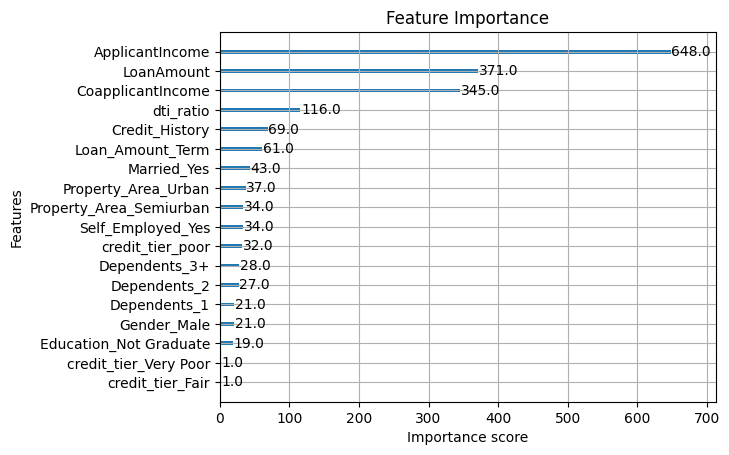

In [104]:
final_model = xg.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,  # You might want to increase this for final model
    max_depth=best_params[0],
    learning_rate=best_params[1],
    subsample=best_params[2],
    colsample_bytree=best_params[3],
    tree_method='hist',
    seed=42
)
final_model.fit(x_trainp, y_trainp)  # Use full training data

test_preds = final_model.predict(x_testp)
test_rmse = np.sqrt(mean_squared_error(y_testp, test_preds))
print(f"Test RMSE: {test_rmse:.4f}")

plot_importance(final_model)
plt.title('Feature Importance')
plt.show()